In [0]:
import numpy as np
from numpy import array
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import string
import os
from PIL import Image
import glob
from pickle import dump, load
from time import time
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import LSTM, Embedding, TimeDistributed, Dense, RepeatVector,\
                         Activation, Flatten, Reshape, concatenate, Dropout, BatchNormalization
from keras.optimizers import Adam, RMSprop
from keras.layers.wrappers import Bidirectional
from keras.layers.merge import add
from keras.applications.inception_v3 import InceptionV3
from keras.preprocessing import image
from keras.models import Model
from keras import Input, layers
from keras import optimizers
from keras.applications.inception_v3 import preprocess_input
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
ls "gdrive/My Drive/LSTM/dataset/images" | wc -l

2817


In [0]:
# load doc into memory
def load_doc(filename):
	# open the file as read only
	file = open(filename, 'r')
	# read all text
	text = file.read()
	# close the file
	file.close()
	return text

filename = "gdrive/My Drive/LSTM/dataset/training_data.txt"
# load descriptions
doc = load_doc(filename)
print(doc[:241])

a1f0fd29e6ae9a8618baac0a27e13676e192ee03c38e79eb9cdb01d32b6e305b.jpg#1  HighCrime
68934fb5c279c38cda8e88fa67d2d6a664ec3fefac07937d2dd603292444f30e.jpg#1  NoCrime
73e74e658d83ec20d35cf16ce461b9538ecdc59ea70ff8442bce8d0c4e1422ef.png#1  NoCrime


In [0]:
def load_descriptions(doc):
	mapping = dict()
	# process lines
	for line in doc.split('\n'):
		# split line by white space
		tokens = line.split()
		if len(line) < 2:
			continue
		# take the first token as the image id, the rest as the description
		image_id, image_desc = tokens[0], tokens[1:]
		# extract filename from image id
		image_id = image_id.split('#1')[0]
		# convert description tokens back to string
		image_desc = ' '.join(image_desc)
		# create the list if needed
		if image_id not in mapping:
			mapping[image_id] = list()
		# store description
		mapping[image_id].append(image_desc)
	return mapping

# parse descriptions
descriptions = load_descriptions(doc)
print('Loaded: %d ' % len(descriptions))

Loaded: 1972 


In [0]:
list(descriptions.keys())[:5]

['a1f0fd29e6ae9a8618baac0a27e13676e192ee03c38e79eb9cdb01d32b6e305b.jpg',
 '68934fb5c279c38cda8e88fa67d2d6a664ec3fefac07937d2dd603292444f30e.jpg',
 '73e74e658d83ec20d35cf16ce461b9538ecdc59ea70ff8442bce8d0c4e1422ef.png',
 '676508fcd73d674bac82600e02b5d58a562a7493046baf6bf08e0f25da44c24e.jpg',
 '7a6c29f171fe6d3b550f24d7650c229e298c67fc2bbef30401f4ef93fab11a6f.jpg']

In [0]:
descriptions['a1f0fd29e6ae9a8618baac0a27e13676e192ee03c38e79eb9cdb01d32b6e305b.jpg']

['HighCrime']

In [0]:
descriptions['68934fb5c279c38cda8e88fa67d2d6a664ec3fefac07937d2dd603292444f30e.jpg']

['NoCrime']

In [0]:
# convert the loaded descriptions into a vocabulary of words
def to_vocabulary(descriptions):
	# build a list of all description strings
	all_desc = set()
	for key in descriptions.keys():
		[all_desc.update(d.split()) for d in descriptions[key]]
	return all_desc

# summarize vocabulary
vocabulary = to_vocabulary(descriptions)
print('Original Vocabulary Size: %d' % len(vocabulary))

Original Vocabulary Size: 3


In [0]:
# save descriptions to file, one per line
def save_descriptions(descriptions, filename):
	lines = list()
	for key, desc_list in descriptions.items():
		for desc in desc_list:
			lines.append(key + ' ' + desc)
	data = '\n'.join(lines)
	file = open(filename, 'w')
	file.write(data)
	file.close()

save_descriptions(descriptions, 'gdrive/My Drive/LSTM/dataset/descriptions.txt')

In [0]:
# load a pre-defined list of photo identifiers
def load_set(filename):
	doc = load_doc(filename)
	dataset = list()
	# process line by line
	for line in doc.split('\n'):
		# skip empty lines
		if len(line) < 1:
			continue
		# get the image identifier
		identifier = line.split('#1')[0]
		dataset.append(identifier)
	return set(dataset)

# load training dataset (6K)
filename = 'gdrive/My Drive/LSTM/dataset/training_data.txt'
train = load_set(filename)
print('Dataset: %d' % len(train))

Dataset: 1972


In [0]:
# Below path contains all the images
images = 'gdrive/My Drive/LSTM/dataset/images/'
# Create a list of all image names in the directory
img = glob.glob(images + '*')
print(img)

['gdrive/My Drive/LSTM/dataset/images/8364666119374c4dfbe3d07d07f73dfbe6695f48c5f2fed687a7b53e2da6107a.png', 'gdrive/My Drive/LSTM/dataset/images/78f20a37fdf44468f554739a138a44e1c86acd79aa8c01dbf442d3d392c5a34d.jpg', 'gdrive/My Drive/LSTM/dataset/images/969586b7e97a1ff05d282ee908989e982f8ce90b606728c643b9df29cce5e267.jpg', 'gdrive/My Drive/LSTM/dataset/images/8b0891c2d36450c0b6a603e2bfb7fed56c307f9ef1959048dfe9b6d68d4df889.png', 'gdrive/My Drive/LSTM/dataset/images/9708bf32fd4df49959f54eb1ae78eb91d507b9f4cf46954c54697c3542f237fe.png', 'gdrive/My Drive/LSTM/dataset/images/904393116374d6765923983812e97f6ec13ea832380cdc5276e058aa7f798814.png', 'gdrive/My Drive/LSTM/dataset/images/8738ac2d79089041063b757aaae558f8ac410cb685812b8d04c6ee4310cd7e6a.jpg', 'gdrive/My Drive/LSTM/dataset/images/982516455587e3de5e5560c88df24756b09a88c6ab1ffce46f1e08b1d42e7907.png', 'gdrive/My Drive/LSTM/dataset/images/85a05240ee9da17ca1031397113ece0e020d6c00d7054b95eddcc257ce3c701d.jpg', 'gdrive/My Drive/LSTM/datas

In [0]:
# Below file conatains the names of images to be used in train data
train_images_file = 'gdrive/My Drive/LSTM/dataset/training_image_list.txt'
# Read the train image names in a set
train_images = set(open(train_images_file, 'r').read().strip().split('\n'))

# Create a list of all the training images with their full path names
train_img = []

for i in img: # img is list of full path names of all images
    if i[len(images):] in train_images: # Check if the image belongs to training set
        train_img.append(i) # Add it to the list of train images

In [0]:
# Below file conatains the names of images to be used in test data
test_images_file = 'gdrive/My Drive/LSTM/dataset/test_image_list.txt'
# Read the validation image names in a set# Read the test image names in a set
test_images = set(open(test_images_file, 'r').read().strip().split('\n'))

# Create a list of all the test images with their full path names
test_img = []

for i in img: # img is list of full path names of all images
    if i[len(images):] in test_images: # Check if the image belongs to test set
        test_img.append(i) # Add it to the list of test images

In [0]:
# load clean descriptions into memory
def load_clean_descriptions(filename, dataset):
	# load document
	doc = load_doc(filename)
	descriptions = dict()
	for line in doc.split('\n'):
		# split line by white space
		tokens = line.split()
		# split id from description
		image_id, image_desc = tokens[0], tokens[1:]
		# skip images not in the set
		if image_id in dataset:
			# create list
			if image_id not in descriptions:
				descriptions[image_id] = list()
			# wrap description in tokens
			desc = 'startseq ' + ' '.join(image_desc) + ' endseq'
			# store
			descriptions[image_id].append(desc)
	return descriptions

# descriptions
train_descriptions = load_clean_descriptions('gdrive/My Drive/LSTM/dataset/descriptions.txt', train)
print('Descriptions: train=%d' % len(train_descriptions))

Descriptions: train=1972


In [0]:
def preprocess(image_path):
    # Convert all the images to size 299x299 as expected by the inception v3 model
    img = image.load_img(image_path, target_size=(299, 299))
    # Convert PIL image to numpy array of 3-dimensions
    x = image.img_to_array(img)
    # Add one more dimension
    x = np.expand_dims(x, axis=0)
    # preprocess the images using preprocess_input() from inception module
    x = preprocess_input(x)
    return x

In [0]:
# Load the inception v3 model
model = InceptionV3(weights='imagenet')

In [0]:
# Create a new model, by removing the last layer (output layer) from the inception v3
model_new = Model(model.input, model.layers[-2].output)

In [0]:
# Function to encode a given image into a vector of size (2048, )
def encode(image):
    image = preprocess(image) # preprocess the image
    fea_vec = model_new.predict(image) # Get the encoding vector for the image
    fea_vec = np.reshape(fea_vec, fea_vec.shape[1]) # reshape from (1, 2048) to (2048, )
    return fea_vec

In [0]:
# Call the funtion to encode all the train images
# This will take a while on CPU - Execute this only once
start = time()
encoding_train = {}
for img in train_img:
    encoding_train[img[len(images):]] = encode(img)
print("Time taken in seconds =", time()-start)

/usr/local/lib/python3.6/dist-packages/PIL/Image.py:914: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')


Time taken in seconds = 56.972394704818726


In [0]:
# Save the bottleneck train features to disk
with open("gdrive/My Drive/LSTM/dataset/Pickle/encoded_train_images.pkl", "wb") as encoded_pickle:
    dump(encoding_train, encoded_pickle)

In [0]:
# Call the funtion to encode all the test images - Execute this only once
start = time()
encoding_test = {}
for img in test_img:
    encoding_test[img[len(images):]] = encode(img)
print("Time taken in seconds =", time()-start)

/usr/local/lib/python3.6/dist-packages/PIL/Image.py:914: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')


Time taken in seconds = 22.93998622894287


In [0]:
# Save the bottleneck test features to disk
with open("gdrive/My Drive/LSTM/dataset/Pickle/encoded_test_images.pkl", "wb") as encoded_pickle:
    dump(encoding_test, encoded_pickle)

In [0]:
train_features = load(open("gdrive/My Drive/LSTM/dataset/Pickle/encoded_train_images.pkl", "rb"))
print('Photos: train=%d' % len(train_features))

Photos: train=1972


In [0]:
# Create a list of all the training captions
all_train_captions = []
for key, val in train_descriptions.items():
    for cap in val:
        all_train_captions.append(cap)
len(all_train_captions)

1973

In [0]:
# Consider only words which occur at least 10 times in the corpus
word_count_threshold = 10
word_counts = {}
nsents = 0
for sent in all_train_captions:
    nsents += 1
    for w in sent.split(' '):
        word_counts[w] = word_counts.get(w, 0) + 1

vocab = [w for w in word_counts if word_counts[w] >= word_count_threshold]
print('preprocessed words %d -> %d' % (len(word_counts), len(vocab)))

preprocessed words 5 -> 5


In [0]:
ixtoword = {}
wordtoix = {}

ix = 1
for w in vocab:
    wordtoix[w] = ix
    ixtoword[ix] = w
    ix += 1

In [0]:
vocab_size = len(ixtoword) + 1 # one for appended 0's
vocab_size

6

In [0]:
# convert a dictionary of clean descriptions to a list of descriptions
def to_lines(descriptions):
	all_desc = list()
	for key in descriptions.keys():
		[all_desc.append(d) for d in descriptions[key]]
	return all_desc

# calculate the length of the description with the most words
def max_length(descriptions):
	lines = to_lines(descriptions)
	return max(len(d.split()) for d in lines)

# determine the maximum sequence length
max_length = max_length(train_descriptions)
print('Description Length: %d' % max_length)

Description Length: 3


In [0]:
# data generator, intended to be used in a call to model.fit_generator()
def data_generator(descriptions, photos, wordtoix, max_length, num_photos_per_batch):
    X1, X2, y = list(), list(), list()
    n=0
    # loop for ever over images
    while 1:
        for key, desc_list in descriptions.items():
            n+=1
            # retrieve the photo feature
            photo = photos[key]
            for desc in desc_list:
                # encode the sequence
                seq = [wordtoix[word] for word in desc.split(' ') if word in wordtoix]
                # split one sequence into multiple X, y pairs
                for i in range(1, len(seq)):
                    # split into input and output pair
                    in_seq, out_seq = seq[:i], seq[i]
                    # pad input sequence
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    # encode output sequence
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                    # store
                    X1.append(photo)
                    X2.append(in_seq)
                    y.append(out_seq)
            # yield the batch data
            if n==num_photos_per_batch:
                yield [[array(X1), array(X2)], array(y)]
                X1, X2, y = list(), list(), list()
                n=0

In [0]:
# Load Glove vectors
glove_dir = 'gdrive/My Drive/LSTM/glove'
embeddings_index = {} # empty dictionary
f = open(os.path.join(glove_dir, 'glove.6B.200d.txt'), encoding="utf-8")

for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()
print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


In [0]:
embedding_dim = 200

# Get 200-dim dense vector for each of the 10000 words in out vocabulary
embedding_matrix = np.zeros((vocab_size, embedding_dim))

for word, i in wordtoix.items():
    #if i < max_words:
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Words not found in the embedding index will be all zeros
        embedding_matrix[i] = embedding_vector

In [0]:
embedding_matrix.shape

(6, 200)

In [0]:
inputs1 = Input(shape=(2048,))
fe1 = Dropout(0.5)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)
inputs2 = Input(shape=(max_length,))
se1 = Embedding(vocab_size, embedding_dim, mask_zero=True)(inputs2)
se2 = Dropout(0.5)(se1)
se3 = LSTM(256)(se2)
decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)
model = Model(inputs=[inputs1, inputs2], outputs=outputs)

In [0]:
model.summary()

Model: "model_9"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_14 (InputLayer)           (None, 3)            0                                            
__________________________________________________________________________________________________
input_13 (InputLayer)           (None, 2048)         0                                            
__________________________________________________________________________________________________
embedding_5 (Embedding)         (None, 3, 200)       1200        input_14[0][0]                   
__________________________________________________________________________________________________
dropout_9 (Dropout)             (None, 2048)         0           input_13[0][0]                   
____________________________________________________________________________________________

In [0]:
model.layers[2]

In [0]:
model.layers[2].set_weights([embedding_matrix])
model.layers[2].trainable = False

In [0]:
model.compile(loss='categorical_crossentropy', optimizer='adam')

In [0]:
epochs = 20
number_pics_per_bath = 3
steps = len(train_descriptions)//number_pics_per_bath

In [0]:
for i in range(epochs):
    generator = data_generator(train_descriptions, train_features, wordtoix, max_length, number_pics_per_bath)
    model.fit_generator(generator, epochs=1, steps_per_epoch=steps, verbose=1)
    model.save('gdrive/My Drive/LSTM/model_weights/model_' + str(i) + '.h5')

Epoch 1/1
657/657 [==============================] - 17s 26ms/step - loss: 0.4836
Epoch 1/1
657/657 [==============================] - 10s 15ms/step - loss: 0.3350
Epoch 1/1
657/657 [==============================] - 10s 15ms/step - loss: 0.3111
Epoch 1/1
657/657 [==============================] - 9s 14ms/step - loss: 0.2917
Epoch 1/1
657/657 [==============================] - 9s 14ms/step - loss: 0.2790
Epoch 1/1
657/657 [==============================] - 10s 15ms/step - loss: 0.2729
Epoch 1/1
657/657 [==============================] - 9s 14ms/step - loss: 0.2605
Epoch 1/1
657/657 [==============================] - 10s 15ms/step - loss: 0.2577
Epoch 1/1
657/657 [==============================] - 10s 15ms/step - loss: 0.2634
Epoch 1/1
657/657 [==============================] - 10s 15ms/step - loss: 0.2521
Epoch 1/1
657/657 [==============================] - 10s 15ms/step - loss: 0.2417
Epoch 1/1
657/657 [==============================] - 10s 15ms/step - loss: 0.2326
Epoch 1/1
657/657 [

In [0]:
model.optimizer.lr = 0.0001
epochs = 10
number_pics_per_bath = 6
steps = len(train_descriptions)//number_pics_per_bath

In [0]:
for i in range(epochs):
    generator = data_generator(train_descriptions, train_features, wordtoix, max_length, number_pics_per_bath)
    model.fit_generator(generator, epochs=1, steps_per_epoch=steps, verbose=1)

Epoch 1/1
328/328 [==============================] - 5s 15ms/step - loss: 0.1837
Epoch 1/1
328/328 [==============================] - 5s 15ms/step - loss: 0.1775
Epoch 1/1
328/328 [==============================] - 5s 15ms/step - loss: 0.1859
Epoch 1/1
328/328 [==============================] - 5s 15ms/step - loss: 0.1798
Epoch 1/1
328/328 [==============================] - 5s 15ms/step - loss: 0.1643
Epoch 1/1
328/328 [==============================] - 5s 15ms/step - loss: 0.1721
Epoch 1/1
328/328 [==============================] - 5s 15ms/step - loss: 0.1637
Epoch 1/1
328/328 [==============================] - 5s 15ms/step - loss: 0.1609
Epoch 1/1
328/328 [==============================] - 5s 15ms/step - loss: 0.1417
Epoch 1/1
328/328 [==============================] - 5s 15ms/step - loss: 0.1521


In [0]:
model.save_weights('gdrive/My Drive/LSTM/model_weights/model_29.h5')

In [0]:
model.load_weights('gdrive/My Drive/LSTM/model_weights/model_29.h5')

In [0]:
images = 'gdrive/My Drive/LSTM/dataset/images/'

In [0]:
with open("gdrive/My Drive/LSTM/dataset/Pickle/encoded_test_images.pkl", "rb") as encoded_pickle:
    encoding_test = load(encoded_pickle)

In [0]:
def greedySearch(photo):
    in_text = 'startseq'
    for i in range(max_length):
        sequence = [wordtoix[w] for w in in_text.split() if w in wordtoix]
        sequence = pad_sequences([sequence], maxlen=max_length)
        yhat = model.predict([photo,sequence], verbose=0)
        yhat = np.argmax(yhat)
        word = ixtoword[yhat]
        in_text += ' ' + word
        if word == 'endseq':
            break
    final = in_text.split()
    final = final[1:-1]
    final = ' '.join(final)
    return final

# Statistics of model captioning test data

## Metrics

In [0]:
filename = "gdrive/My Drive/LSTM/dataset/test_data.txt"
# load test descriptions
test_doc = load_doc(filename)
test_descriptions = load_descriptions(test_doc)

In [0]:
from sklearn.metrics import classification_report

key_list = list(encoding_test.keys())
predictions = []
actual = []
target_names = ['NoCrime','LowCrime','HighCrime']

# Get predicitions
for i in range(len(key_list)):
  pic = key_list[i]
  image = encoding_test[pic].reshape((1,2048))
  predictions.append(greedySearch(image))
  actual.append(test_descriptions[pic][0])
  
  
print(classification_report(actual,predictions,target_names=target_names))

NameError: ignored

## Test of random 20 images in test data with visuals

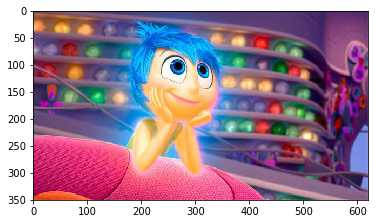

Caption: NoCrime


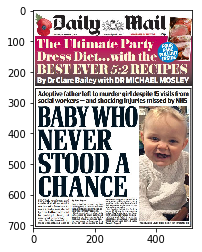

Caption: NoCrime


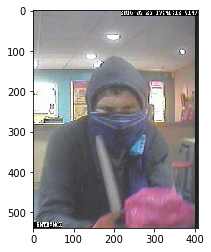

Caption: LowCrime


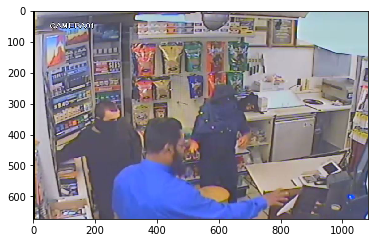

Caption: LowCrime


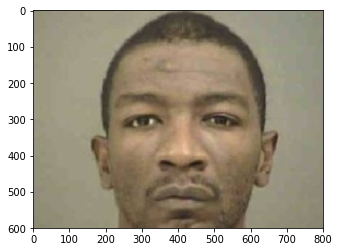

Caption: NoCrime


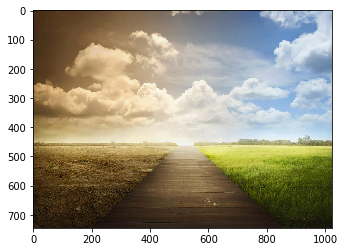

Caption: NoCrime


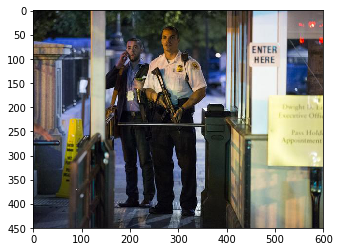

Caption: NoCrime


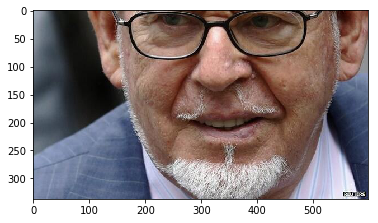

Caption: NoCrime


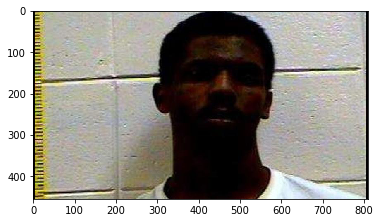

Caption: NoCrime


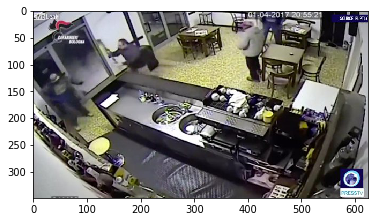

Caption: HighCrime


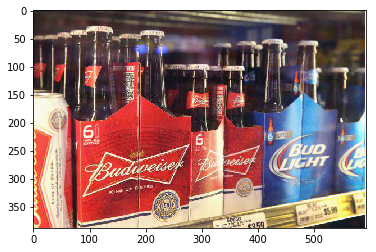

Caption: NoCrime


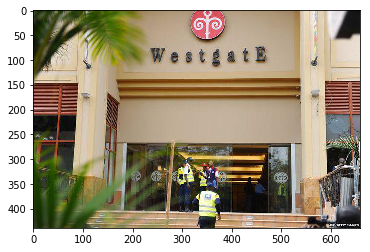

Caption: NoCrime


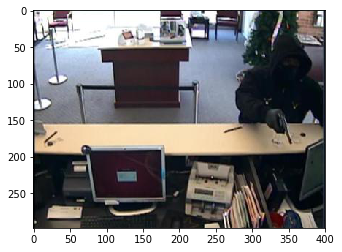

Caption: HighCrime


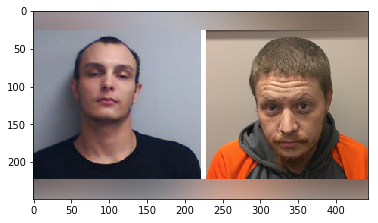

Caption: NoCrime


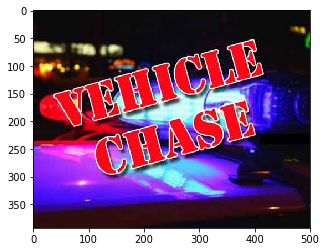

Caption: NoCrime


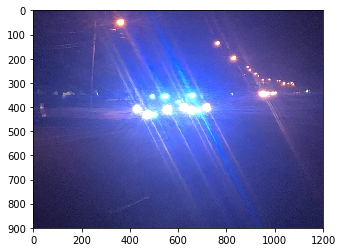

Caption: NoCrime


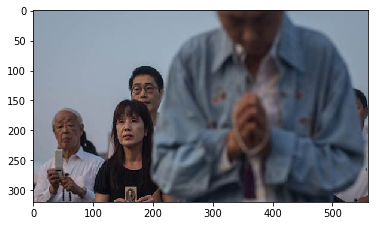

Caption: NoCrime


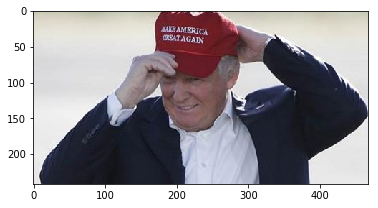

Caption: NoCrime


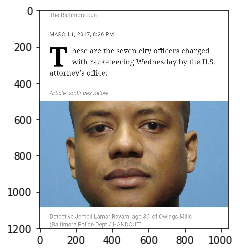

Caption: NoCrime


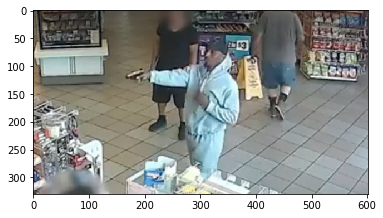

Caption: LowCrime


In [0]:
from random import randint
for i in range(20):
  pic = list(encoding_test.keys())[randint(0,len(key_list))]
  image = encoding_test[pic].reshape((1,2048))
  x=plt.imread(images+pic)
  plt.imshow(x)
  plt.show()
  print("Caption:",greedySearch(image))